TASK-2 Titanic classification of survival and non-survival passengers

In [3]:
import numpy as np
import pandas as pd
import ydata_profiling

In [4]:
# Data Visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

In [5]:
# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
from google.colab import files

# Upload the 'train.csv' file
uploaded = files.upload()

# After running the above code, you will be prompted to select and upload the file.
# Repeat the process for the 'test.csv' file if needed.


Saving test.csv to test.csv


In [14]:
from google.colab import files

# Upload the 'train.csv' file
uploaded = files.upload()

# After running the above code, you will be prompted to select and upload the file.
# Repeat the process for the 'test.csv' file if needed.


Saving train.csv to train.csv


In [15]:
!ls /content/

drive  sample_data  test.csv  train.csv


In [16]:
import pandas as pd

# Read the train CSV file into a dataframe
train_df = pd.read_csv('/content/train.csv')

# Read the test CSV file into a dataframe
test_df = pd.read_csv('/content/test.csv')


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [18]:
train_df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

38% out of the training-set servived the titanic. We can also see that the passenger ages range from 0.4 to 80.

In [19]:
pp.ProfileReport(train_df, title= 'Pandas Profile report of "Train" set', html= {'style':{'full_width': True}})

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

Total     %
Cabin          687  77.1
Age            177  19.9
Embarked         2   0.2
PassengerId      0   0.0
Survived         0   0.0

Text(0.5, 1.0, 'Male')

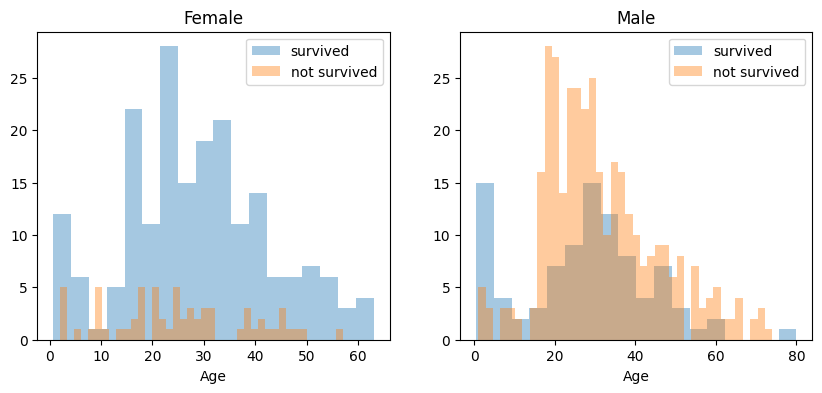

In [21]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']
ax = sns.distplot(women[women['Survived'] == 1].Age.dropna(), bins= 18, label= survived, ax= axes[0], kde= False)
ax.legend()
ax = sns.distplot(women[women['Survived'] == 0].Age.dropna(), bins= 40, label= not_survived, ax= axes[0], kde= False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived'] == 1].Age.dropna(), bins= 18, label= survived, ax= axes[1], kde= False)
ax.legend()
ax = sns.distplot(men[men['Survived'] == 0].Age.dropna(), bins= 40, label= not_survived, ax= axes[1], kde= False)
ax.legend()
ax.set_title('Male')

3.SibSp and Parch SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic.

In [22]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
    # print(dataset)

train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

In [23]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

# We can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
train_df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Embarked  relatives  not_alone  Deck  
0        0         A/5 21171   7.2500        S          1          0     8  
1        0          PC 17599  71.2833        C          1          0     3  
2        0  STON/O2. 3101282   7.9250        S          0          1     8  
3        0            113803  53.1000        S          1          0     3  
4        0            373450   8.0500        S          0          1     8  
..     ...               ...      ...      ...        ...        ...   ...  
886      0            211536  13.0000        S          0          1     8  
887      0            112053  30.0000        S          0          1     2  
888      2        W./C. 6607  23.4500        S          3          0     8  
889      0            111369  30.0000        C          0          1     3  
890      0            370376   7.7500        Q          0          1     8  

[891 rows x 14 columns]

In [24]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df['Age'].mean()
    std = test_df['Age'].std()
    is_null = dataset['Age'].isnull().sum()
    # Compute random number between mean , std and is_null
    rand_age = np.random.randint(mean - std, mean + std, is_null)
    age_slice = dataset['Age'].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset['Age'] = age_slice
    dataset['Age'] = train_df['Age'].astype(int)

train_df['Age'].isnull().sum()

0

In [25]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [26]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

train_df['Embarked'].isnull().sum()

0

In [27]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    int64  
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  relatives    891 non-null    int64  
 12  not_alone    891 non-null    int64  
 13  Deck         891 non-null    int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 97.6+ KB


In [28]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)


In [29]:
data = [train_df, test_df]
titles = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}

for dataset in data:
    # Extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([a-zA-Z]+)\.', expand= False)
    # Replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Cap', 'Col', 'Don', 'Dr'\
                                                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # Filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Title'] = dataset['Title'].astype(int)

train_df = train_df.drop(['Name'], axis= 1)
test_df = test_df.drop(['Name'], axis= 1)

In [30]:
genders = {'male': 0, 'female': 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [31]:
train_df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [32]:
train_df = train_df.drop(['Ticket'], axis= 1)
test_df = test_df.drop(['Ticket'], axis= 1)


In [33]:
ports = {'S': 0, 'C': 1, 'Q': 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [34]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed
train_df['Age'].value_counts()

4    165
6    164
5    146
3    140
2    111
1     97
0     68
Name: Age, dtype: int64

In [35]:
train_df.head()

PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  \
0            1         0       3    0    2      1      0     7         0   
1            2         1       1    1    5      1      0    71         1   
2            3         1       3    1    3      0      0     7         0   
3            4         1       1    1    5      1      0    53         0   
4            5         0       3    0    5      0      0     8         0   

   relatives  not_alone  Deck  Title  
0          1          0     8      1  
1          1          0     3      3  
2          0          1     8      2  
3          1          0     3      3  
4          0          1     8      1

In [36]:
data = [train_df, test_df]
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# let's see how it's distributed
train_df['Fare'].value_counts()

0    241
2    223
1    216
3    158
4     44
5      9
Name: Fare, dtype: int64

In [37]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']


In [38]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare'] / (dataset['relatives'] + 1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  \
0            1         0       3    0    2      1      0     0         0   
1            2         1       1    1    5      1      0     3         1   
2            3         1       3    1    3      0      0     0         0   
3            4         1       1    1    5      1      0     3         0   
4            5         0       3    0    5      0      0     1         0   
5            6         0       3    0    4      0      0     1         2   
6            7         0       1    0    6      0      0     3         0   
7            8         0       3    0    0      3      1     2         0   
8            9         1       3    1    3      0      2     1         0   
9           10         1       2    1    1      1      0     2         1   

   relatives  not_alone  Deck  Title  Age_Class  Fare_Per_Person  
0          1          0     8      1          6                0  
1          1          0     3      3          5                1  
2          0          1     8      2          9                0  
3          1          0     3      3          5                1  
4          0          1     8      1         15                1  
5          0          1     8      1         12                1  
6          0          1     5      1          6                3  
7          4          0     8      4          0                0  
8          2          0     8      3          9                0  
9          1          0     8      3          2                1

In [39]:
X_train = train_df.drop(['Survived'], axis= 1)
Y_train = train_df['Survived']
X_Test = test_df.drop(['PassengerId'], axis= 1).copy()


K-Nearest Neighbor

In [40]:
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train, Y_train)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)


Logistic Regression:

In [41]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, Y_train)
acc_logreg = round(logreg.score(X_train, Y_train) * 100, 2)

Random Forest:

In [42]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [43]:
results = pd.DataFrame({'Model': ['KNN', 'Logestic Regresion', 'Random Forest'],\
                       'Score': [acc_knn, acc_logreg, acc_random_forest]})
result_df = results.sort_values(by= 'Score', ascending= False)
result_df = result_df.set_index('Score')
result_df.head()

Model
Score                     
100.00       Random Forest
82.15   Logestic Regresion
78.68                  KNN

K-Fold Cross Validation

In [44]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators= 100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring= "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.76666667 0.7752809  0.76404494 0.78651685 0.82022472 0.82022472
 0.87640449 0.78651685 0.79775281 0.83146067]
Mean: 0.8025093632958802
Standard Deviation: 0.03311507469973168


Feature importance

In [45]:
importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(random_forest.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending= False).set_index('feature')

importances.head(15)

importance
feature                    
PassengerId           0.237
Title                 0.161
Sex                   0.138
Age_Class             0.072
Pclass                0.061
Deck                  0.058
Age                   0.054
Fare                  0.051
relatives             0.044
Embarked              0.036
Fare_Per_Person       0.034
SibSp                 0.029
Parch                 0.016
not_alone             0.009

<Axes: xlabel='feature'>

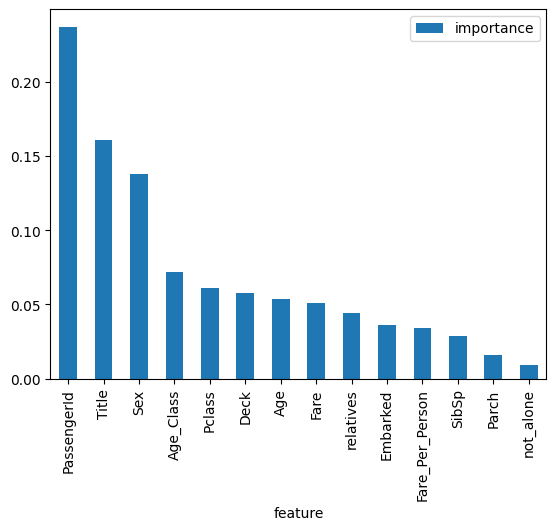

In [46]:
importances.plot.bar()

In [47]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)


In [48]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score= True)
random_forest.fit(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest, 2), '%')

100.0 %
